In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [2]:
#Dataset Paths 
BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

CSV_PATH   = os.path.join(BASE_PATH, "csvs")
AUDIO_PATH = os.path.join(BASE_PATH, "audios")

In [3]:
#Load CSV Files
train_df = pd.read_csv(os.path.join(CSV_PATH, "train.csv"))
test_df  = pd.read_csv(os.path.join(CSV_PATH, "test.csv"))

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))
train_df.head()

Train samples: 409
Test samples: 197


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


In [4]:
#Verify Audio Files
print(os.listdir(os.path.join(AUDIO_PATH, "train"))[:5])
print(os.listdir(os.path.join(AUDIO_PATH, "test"))[:5])

['audio_49.wav', 'audio_77_2.wav', 'audio_90.wav', 'audio_77.wav', 'audio_66.wav']
['audio_49.wav', 'audio_67_1.wav', 'audio_90.wav', 'audio_77.wav', 'audio_20_1.wav']


In [5]:
#Audio Feature Extraction Function
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    features = {}

    # Duration
    features["duration"] = librosa.get_duration(y=y, sr=sr)

    # Energy
    rms = librosa.feature.rms(y=y)
    features["rms_mean"] = np.mean(rms)
    features["rms_std"] = np.std(rms)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features["zcr_mean"] = np.mean(zcr)
    features["zcr_std"] = np.std(zcr)

    # Spectral features
    features["spectral_centroid"] = np.mean(
        librosa.feature.spectral_centroid(y=y, sr=sr)
    )
    features["spectral_bandwidth"] = np.mean(
        librosa.feature.spectral_bandwidth(y=y, sr=sr)
    )

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f"mfcc_{i}_mean"] = np.mean(mfccs[i])
        features[f"mfcc_{i}_std"]  = np.std(mfccs[i])

    return features


In [6]:
#Test Feature Extraction on ONE Audio
sample_path = os.path.join(
    AUDIO_PATH,
    "train",
    train_df.iloc[0]["filename"] + ".wav"
)
extract_audio_features(sample_path)


/tmp/ipykernel_13/2822539450.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


{'duration': 60.074666666666666,
 'rms_mean': 0.040349405,
 'rms_std': 0.044357784,
 'zcr_mean': 0.09291550974724835,
 'zcr_std': 0.0788141439672056,
 'spectral_centroid': 3451.81584982763,
 'spectral_bandwidth': 3148.979827893351,
 'mfcc_0_mean': -375.53604,
 'mfcc_0_std': 126.995026,
 'mfcc_1_mean': 97.66552,
 'mfcc_1_std': 81.46304,
 'mfcc_2_mean': -21.86693,
 'mfcc_2_std': 40.147655,
 'mfcc_3_mean': 23.214952,
 'mfcc_3_std': 33.953342,
 'mfcc_4_mean': 13.344821,
 'mfcc_4_std': 28.995243,
 'mfcc_5_mean': 12.039976,
 'mfcc_5_std': 19.813042,
 'mfcc_6_mean': -8.032814,
 'mfcc_6_std': 17.697176,
 'mfcc_7_mean': -1.4867934,
 'mfcc_7_std': 14.012511,
 'mfcc_8_mean': -1.8864174,
 'mfcc_8_std': 12.017157,
 'mfcc_9_mean': -9.401303,
 'mfcc_9_std': 14.900572,
 'mfcc_10_mean': 2.0187478,
 'mfcc_10_std': 10.73232,
 'mfcc_11_mean': -4.81376,
 'mfcc_11_std': 12.4416065,
 'mfcc_12_mean': -8.720222,
 'mfcc_12_std': 14.512632}

In [7]:
#Extract Features for ALL Training Data
from tqdm import tqdm

train_features = []

for fname in tqdm(train_df["filename"]):
    audio_path = os.path.join(AUDIO_PATH, "train", fname + ".wav")
    train_features.append(extract_audio_features(audio_path))

X_train = pd.DataFrame(train_features)
y_train = train_df["label"]

print("Training feature shape:", X_train.shape)


  0%|          | 0/409 [00:00<?, ?it/s]/tmp/ipykernel_13/2822539450.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 1/409 [00:01<10:17,  1.51s/it]/tmp/ipykernel_13/2822539450.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 3/409 [00:03<06:36,  1.02it/s]/tmp/ipykernel_13/2822539450.py:3: UserWarning: PySound

Training feature shape: (409, 33)


In [8]:
#Extract Features for Test Data
test_features = []

for fname in tqdm(test_df["filename"]):
    audio_path = os.path.join(AUDIO_PATH, "test", fname + ".wav")
    test_features.append(extract_audio_features(audio_path))

X_test = pd.DataFrame(test_features)

print("Test feature shape:", X_test.shape)


  3%|▎         | 6/197 [00:03<01:46,  1.79it/s]/tmp/ipykernel_13/2822539450.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 13/197 [00:07<01:40,  1.82it/s]/tmp/ipykernel_13/2822539450.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 33/197 [00:24<01:47,  1.53it/s]/tmp/ipykernel_13/2822539450.py:3: UserWarnin

Test feature shape: (197, 33)


In [9]:
#Train–Validation Split
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42
)


In [10]:
#Train Regression Model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_tr, y_tr)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [11]:
#TRAINING RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

train_preds = model.predict(X_tr)
train_rmse = np.sqrt(mean_squared_error(y_tr, train_preds))

print(" Training RMSE:", train_rmse)


 Training RMSE: 0.2679572886911105


In [12]:
#Validation Metrics
from scipy.stats import pearsonr

val_preds = model.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
pearson_corr, _ = pearsonr(y_val, val_preds)

print("Validation RMSE:", val_rmse)
print("Pearson Correlation:", pearson_corr)


Validation RMSE: 0.6725002833438518
Pearson Correlation: 0.5145778433288254


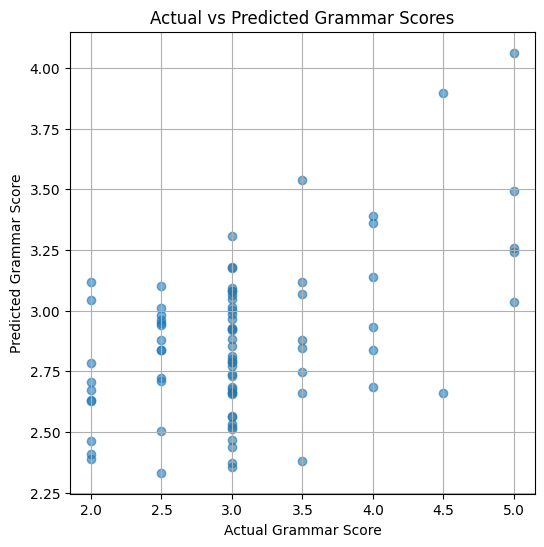

In [13]:
#Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, val_preds, alpha=0.6)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Actual vs Predicted Grammar Scores")
plt.grid()
plt.show()


In [14]:
#Train Final Model on FULL Training Data
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [15]:
#Predict on Test Data
test_predictions = model.predict(X_test)
test_predictions = np.clip(test_predictions, 0, 5)


In [16]:
#Submission File
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_predictions
})

submission.to_csv("submission.csv", index=False)
submission.head()


,filename,label
0,audio_141,2.8000
1,audio_114,2.7375
2,audio_17,2.7925
3,audio_76,4.0525
4,audio_156,2.7100


In [17]:
submission.shape


(197, 2)